In [1]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# ls /content/drive/MyDrive/

In [4]:
# Copy the dataset from Google Drive to local

!cp "/content/drive/MyDrive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [5]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

TensorFlow 1.x selected.


# Data pre-processing

**0->mass 1->calcification**

In [6]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None


The data is prepared following these steps:

1. Import the training and testing data from numpy arrays

2. Remove the images and labels related to baseline patches (even indices in the arrays)

3. Adjust the labels for the binary classification problem, so that 0 corresponds to 'mass' and 1 maps to 'calcification'
Normalize the pixels to be in the range (0-1) floating point

4. Shuffle the training set (and labels accordingly, of course)

5. Split the training data into 'training' and 'validation' subsets

6. Build Keras generators for training and validation data

In [7]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_label(l) for l in train_labels])
test_labels = np.array([remap_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')

Train size: 2676 	 Test size: 336
Image size: 150x150


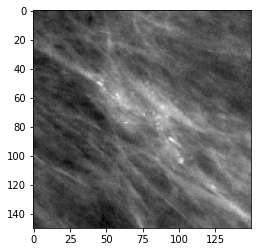

Label: 1


In [8]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

# Classification

The first step is to discover how large the model should be approximately. A network that is too small won't be able to generalize well; on the other side, a model with too many parameters may learn slowly and overfit.

A good way to find the appropriate size is to start from a small naive model, then gradually increase its size until it starts overfitting while learning; at that point it is flexible enough to fit the training data, and potentially generalizable to other data with a proper training.

Of course, the model can be refined later, by adding new layers, modifying existing ones, including regularization techniques or tuning the hyperparameters, in order to achieve (hopefully) better performances.

## Experiment 0

Let's start with a very small CNN, made of 2 convolutional layers interleaved with max-pooling. At the end, after a fully-connect layer, a single neuron with sigmoid activation generates the output (binary classification).

As already mentioned, the aim is to get a rough idea of the required model complexity.



In [9]:
# Build a simple model
# Model 0

model_0 = models.Sequential()
model_0.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Flatten())
model_0.add(layers.Dense(16, activation='relu'))
model_0.add(layers.Dense(1, activation='sigmoid'))

model_0.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                1327120   
_________________________________________

The loss function is the binary cross-entropy, which is particularly suitable for this kind of problem (binary classification). The optimizer is RMSprop, an adaptive optimization algorithm which is considered quite efficient. During the training, we monitor how the loss evolves on the validation set too and save the corresponding model weights when that loss is minimum, since it is where the model usually performs best.

In [10]:
# mkdir /content/drive/MyDrive/models

In [11]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_0_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_0.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_0 = model_0.fit_generator(
        train_generator,
        steps_per_epoch=int(0.8*n_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_0, 'model_0_2cl_end.h5')
!cp model* "/content/drive/MyDrive/models/"

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6918 - acc: 0.5308
Epoch 00001: val_loss improved from inf to 0.69176, saving model to model_0_2cl_best.h5
66/66 [==============================] - 60s 904ms/step - loss: 0.7689 - acc: 0.5325 - val_loss: 0.6918 - val_acc: 0.5308
Epoch 2/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6768 - acc: 0.5570
Epoch 00002: val_loss improved from 0.69176 to 0.67675, saving model to model_0_2cl_best.h5
66/66 [==============================] - 58s 878ms/step - loss: 0.6845 - acc: 0.5524 - val_loss: 0.6768 - val_acc: 0.5570
Epoch 3/100
17/66 [======>.......................] - ETA: 11s - loss: 0.6724 - acc: 0.5383
Epoch 00003: val_loss improved from 0.67675 to 0.67237, saving model to model_0_2cl_best.h5
66/66 [==============================] - 58s 878ms/step - loss: 0.6740 - acc: 0.6197 - val_loss: 0.6724 - val_acc: 0.

In [12]:
# History of accuracy and loss
tra_loss_0 = history_0.history['loss']
tra_acc_0 = history_0.history['acc']
val_loss_0 = history_0.history['val_loss']
val_acc_0 = history_0.history['val_acc']

# Total number of epochs training
epochs_0 = range(1, len(tra_acc_0)+1)
end_epoch_0 = len(tra_acc_0)

# Epoch when reached the validation loss minimum
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Loss and accuracy on the validation set
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0-1]
opt_val_acc_0 = val_acc_0[opt_epoch_0-1]

# Loss and accuracy on the test set
opt_model_0 = models.load_model('model_0_2cl_best.h5')
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)
opt_pred_0 = opt_model_0.predict([test_images, test_labels])
pred_classes_0 = np.rint(opt_pred_0)

print("Model 0\n")

print("Epoch [end]: %d" % end_epoch_0)
print("Epoch [opt]: %d" % opt_epoch_0)
print("Valid accuracy [end]: %.4f" % end_val_acc_0)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_0)
print("Test accuracy [end]:  %.4f" % test_acc_0)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_0)
print("Valid loss [end]: %.4f" % end_val_loss_0)
print("Valid loss [opt]: %.4f" % opt_val_loss_0)
print("Test loss [end]:  %.4f" % test_loss_0)
print("Test loss [opt]:  %.4f" % opt_test_loss_0)

print(classification_report(test_labels, pred_classes_0, digits=4))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model 0

Epoch [end]: 100
Epoch [opt]: 19
Valid accuracy [end]: 0.8262
Valid accuracy [opt]: 0.8318
Test accuracy [end]:  0.7827
Test accuracy [opt]:  0.7827
Valid loss [end]: 1.3548
Valid loss [opt]: 0.4150
Test loss [end]:  1.5419
Test loss [opt]:  0.4548
              precision    recall  f1-score   support

           0     0.8272    0.7486    0.7859       179
           1     0.7414    0.8217    0.7795       157

    accuracy                         0.7827       336
   macro avg     0.7843    0.7851    0.7827       336
weighted avg     0.7871    0.7827    0.7829       336



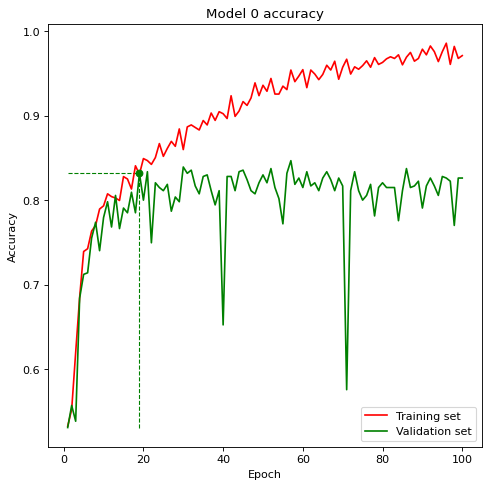

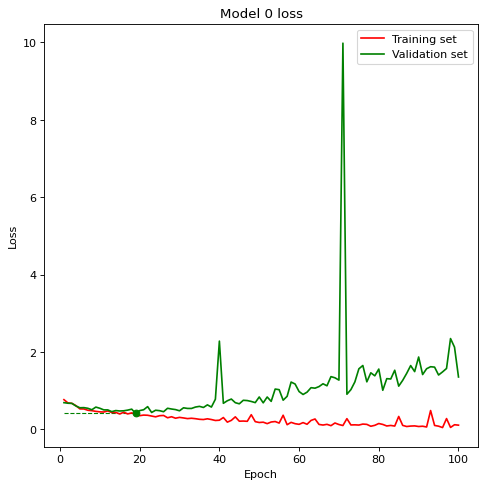

In [13]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

# Experiment 6

In [14]:
# Model 6

model_6 = models.Sequential()
model_6.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(48, activation='relu'))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 15, 15, 256)      

In [15]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_6_2cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_6.compile(optimizer=RMSprop(learning_rate=0.001, decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_6 = model_6.fit_generator(
        train_generator,
        steps_per_epoch=n_train_img // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save
models.save_model(model_6, 'model_6_2cl_end.h5')

Epoch 1/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6928 - acc: 0.5308
Epoch 00001: val_loss improved from inf to 0.69275, saving model to model_6_2cl_best.h5
20/20 [==============================] - 37s 2s/step - loss: 0.7346 - acc: 0.5266 - val_loss: 0.6928 - val_acc: 0.5308
Epoch 2/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6914 - acc: 0.5308
Epoch 00002: val_loss improved from 0.69275 to 0.69138, saving model to model_6_2cl_best.h5
20/20 [==============================] - 36s 2s/step - loss: 0.6935 - acc: 0.5463 - val_loss: 0.6914 - val_acc: 0.5308
Epoch 3/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6901 - acc: 0.5308
Epoch 00003: val_loss improved from 0.69138 to 0.69009, saving model to model_6_2cl_best.h5
20/20 [==============================] - 36s 2s/step - loss: 0.6918 - acc: 0.5500 - val_loss: 0.6901 - val_acc: 0.5308
Epoch 4/500
17/20 [========================>.....] - ETA: 1s - loss: 0.6925 - acc: 0.5308
Epoch 00004

In [16]:
!cp model* "/content/drive/MyDrive/models/"

In [17]:
# History of accuracy and loss
tra_loss_6 = history_6.history['loss']
tra_acc_6 = history_6.history['acc']
val_loss_6 = history_6.history['val_loss']
val_acc_6 = history_6.history['val_acc']

# Total number of epochs training
epochs_6 = range(1, len(tra_acc_6)+1)
end_epoch_6 = len(tra_acc_6)

# Epoch when reached the validation loss minimum
opt_epoch_6 = val_loss_6.index(min(val_loss_6)) + 1

# Loss and accuracy on the validation set
end_val_loss_6 = val_loss_6[-1]
end_val_acc_6 = val_acc_6[-1]
opt_val_loss_6 = val_loss_6[opt_epoch_6-1]
opt_val_acc_6 = val_acc_6[opt_epoch_6-1]

# Loss and accuracy on the test set
opt_model_6 = models.load_model('model_6_2cl_best.h5')
test_loss_6, test_acc_6 = model_6.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_6, opt_test_acc_6 = opt_model_6.evaluate(test_images, test_labels, verbose=False)
opt_pred_6 = opt_model_6.predict([test_images, test_labels])
pred_classes_6 = np.rint(opt_pred_6)

print("Model 6\n")

print("Epoch [end]: %d" % end_epoch_6)
print("Epoch [opt]: %d" % opt_epoch_6)
print("Valid accuracy [end]: %.4f" % end_val_acc_6)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_6)
print("Test accuracy [end]:  %.4f" % test_acc_6)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_6)
print("Valid loss [end]: %.4f" % end_val_loss_6)
print("Valid loss [opt]: %.4f" % opt_val_loss_6)
print("Test loss [end]:  %.4f" % test_loss_6)
print("Test loss [opt]:  %.4f" % opt_test_loss_6)

print(classification_report(test_labels, pred_classes_6, digits=4))

Model 6

Epoch [end]: 250
Epoch [opt]: 170
Valid accuracy [end]: 0.8654
Valid accuracy [opt]: 0.8561
Test accuracy [end]:  0.8512
Test accuracy [opt]:  0.8512
Valid loss [end]: 0.3933
Valid loss [opt]: 0.3455
Test loss [end]:  0.5160
Test loss [opt]:  0.4271
              precision    recall  f1-score   support

           0     0.8274    0.9106    0.8670       179
           1     0.8849    0.7834    0.8311       157

    accuracy                         0.8512       336
   macro avg     0.8562    0.8470    0.8491       336
weighted avg     0.8543    0.8512    0.8502       336



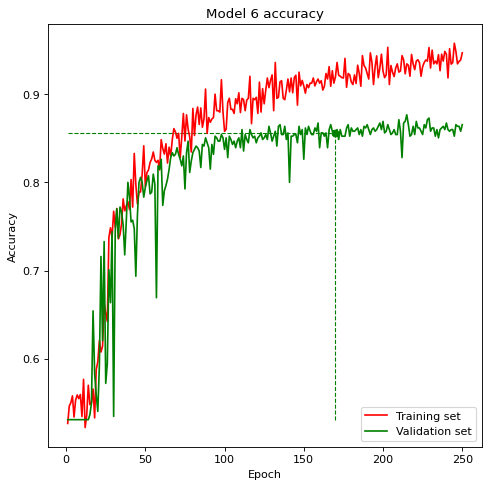

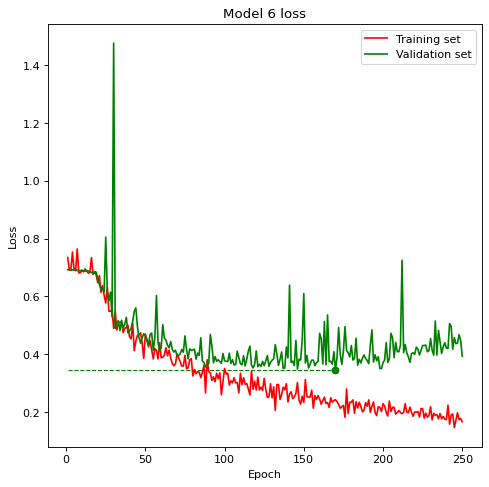

In [18]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_acc_6, 'r', label='Training set')
plt.plot(epochs_6, val_acc_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_acc_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_acc_6), opt_val_acc_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_loss_6, 'r', label='Training set')
plt.plot(epochs_6, val_loss_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_loss_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_loss_6), opt_val_loss_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend();